
## Example magnification bias calculation for CMASS
In this notebook we 
show how we calculate the magnification bias for the example of CMASS. 

author: Lukas Wenzl

In [1]:
#basic imports

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

from scipy.optimize import curve_fit
from scipy.linalg import sqrtm


#import the magnification bias module which contains most of the code
#note: preprocessing of interpolators takes around 20sec
import magnification_bias_SDSS



#force reload for developement
#import importlib
#importlib.reload(magnification_bias_SDSS)


building interpolator for psf correction


## Loading the CMASS dataset

note: first download the data. See the download_data.sh shell script.

In [3]:
#loading CMASS dataset

#CMASS data
data_folder = "SDSS_DR12/"
filename_N_CMASS = data_folder+"galaxy_DR12v5_CMASS_North.fits"
filename_S_CMASS = data_folder+"galaxy_DR12v5_CMASS_South.fits"

#load data
data_CMASS_fits, hdu = magnification_bias_SDSS.load_SDSS_data([filename_N_CMASS, filename_S_CMASS], catalog_idx=1)
print(len(Table(data_CMASS_fits)["Z"]))
#apply redshift cuts
data_CMASS_fits = magnification_bias_SDSS.apply_redshift_cuts(data_CMASS_fits, zmin = 0.43, zmax = 0.75)

#convert format
data_CMASS = Table(data_CMASS_fits)
#calculate all the extinction corrected fluxes and extra columns
data_CMASS = magnification_bias_SDSS.add_extra_columns_to_data(data_CMASS)

#reapplying the photometric selection (should remove very few object, only due to numerical inaccuracy)
#note: removing them changes alpha by roughy 0.01 for CMASS, negligible difference
all_cond, each_condition = magnification_bias_SDSS.reapply_photocuts_CMASS(cModelMag_new= data_CMASS["cModelMag_EC"], modelMag_new = data_CMASS["modelMag_EC"], fiber2Mag_new= data_CMASS["fiber2Mag_EC"], psfMag_new= data_CMASS["psfMag_EC"], dperp= data_CMASS["dperp"])
print("Fraction of objects that fullfill baseline photometric selection = {}".format(np.sum(all_cond)/len(all_cond)))
print(np.sum(all_cond)-len(all_cond))
data_CMASS = data_CMASS[all_cond]

loading multiple galaxy catalog files. They need to have the same data format
loading galaxy catalog SDSS_DR12/galaxy_DR12v5_CMASS_North.fits
loading galaxy catalog SDSS_DR12/galaxy_DR12v5_CMASS_South.fits
849637
Fraction of objects that fullfill baseline photometric selection = 0.999735280272012
-212


## Simple estimate with single step size



In [4]:
magnification_bias_SDSS.calculate_alpha_simple_CMASS(data_CMASS, kappa=0.01)

base error: 0.012763956328853965
N0 error: 0.0029120670434345463
combined error: 0.01309193322738658
-------
Overall alpha without R= 2.6953620836138725
R = 75532.7632330277 (not added)
base error: 0.0
N0 error: 0.0
combined error: 0.0
Condition 1 shifts alpha by 0.0. left removed 0, right removed 0 gal
base error: 0.009891677473206073
N0 error: 0.0018112802381148835
combined error: 0.010056143362886091
Condition 2 shifts alpha by 1.6764916479587555. left removed 0, right removed -26896 gal
base error: 0.0072429080319125205
N0 error: 0.0009700926731797154
combined error: 0.00730758486459787
Condition 3 shifts alpha by 0.8979020640254021. left removed -8, right removed -14293 gal
base error: 0.0
N0 error: 0.0
combined error: 0.0
Condition 4 shifts alpha by 0.0. left removed 0, right removed 0 gal
base error: 0.0038993162888800725
N0 error: 0.00028146384421973353
combined error: 0.003909461525111663
Condition 5 shifts alpha by 0.26051837485283613. left removed 0, right removed -4029 gal


(2.6953620836138725, 0.012763956328853965)

getting for CMASS with a fixed kappa step size of 0.01

$$\alpha_{\rm simple} = 2.70$$

## Full estimate marginalizing the step size

In [5]:
#calculate the binwise estimate (computationally intensive step)
dkappa = 0.002
kappas_fullrange = np.arange(0, 0.06+dkappa, dkappa)
result_CMASS = magnification_bias_SDSS.calculate_alpha_CMASS(data_CMASS, kappas_fullrange)
result_CMASS

starting CMASS
weighted mean redshift = 0.552
R = 219914.41231407764
R/2N= 0.1283489159351181
Not including R in the alpha simple estimate
43.18458669271497 1.5423066675969632
PTE = 0.03340135722388769


{'dNs': array([     0.    ,   9416.    ,  18684.1875,  27897.6875,  36997.125 ,
         46182.625 ,  55196.5625,  64237.5   ,  73268.625 ,  82007.5625,
         90937.25  ,  99704.5   , 108501.375 , 117534.9375, 126376.5   ,
        135153.8125, 143598.75  , 152261.75  , 161019.6875, 169500.375 ,
        178057.125 , 186506.875 , 194770.8125, 202868.5625, 210954.6875,
        219241.75  , 227409.5   , 235243.0625, 243255.125 , 251236.5625,
        258981.375 ]),
 'kappas': array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 ]),
 'N0': 856705.4,
 'R': 219914.41231407764,
 'R_over2N0': 0.1283489159351181,
 'dNs_bins': array([9416.    , 9268.1875, 9213.5   , 9099.4375, 9185.5   , 9013.9375,
        9040.9375, 9031.125 , 8738.9375, 8929.6875, 8767.25  , 8796.875 ,
        9033.5625, 8841.5625, 8777

In [6]:
#Helper function to do the linear fit for our bin wise estimator
def plot_fit_uptomax(result, ii_min, ii_max, title, systematic_error_kappa_step= 0.02, xlim = 0.1, ylim=None):
    kappa_step = result["kappas"][1] - result["kappas"][0]
    effective_kappas = result["kappas"][1:] - (kappa_step/2.)
    xdats = effective_kappas[ii_min:ii_max] 
    ydats = result["As"][ii_min:ii_max]
    sigmas = result["As_error"][ii_min:ii_max]
    fit = magnification_bias_SDSS.fit_linear(xdats, ydats, sigmas)
    func = lambda x, a, c: a*x +  c
    
    plt.errorbar(effective_kappas[:ii_max], result["As"][:ii_max], yerr=result["As_error"][:ii_max], fmt=".")
    plt.errorbar(effective_kappas[ii_max:], result["As"][ii_max:], yerr=result["As_error"][ii_max:], fmt=".", alpha = 0.2, color="grey")


    best_fit = func( result["kappas"], fit["slope_fit"], fit["alpha_fit"])
    sys_err = fit["slope_fit"] * systematic_error_kappa_step
    print("{} sys_err = {}".format(title, sys_err))
    plt.plot(result["kappas"], best_fit,  label=r"$\hat \alpha = {:.2f} \pm {:.2f}, \beta_{{\rm sys}} =  {:.1f} \pm {:.1f},$".format(fit["alpha_fit"], fit["alpha_fit_error"], fit["slope_fit"], fit["slope_fit_error"]))
    fit_mean, fit_std = magnification_bias_SDSS.get_uncertainty_band(func, result["kappas"], [fit["slope_fit"], fit["alpha_fit"]], fit["cov"])
    
    plt.fill_between(result["kappas"], best_fit-fit_std, best_fit+fit_std, alpha= 0.3)
    plt.xlim(0., xlim)
    if(ylim is not None):
        plt.ylim(*ylim)


    plt.axvspan(effective_kappas[ii_max]-(kappa_step/2.), 0.4, alpha=0.2, color="grey")
    plt.ylabel("A")
    plt.xlabel("$\kappa$ bins")

    handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
    import matplotlib.patches as mpatches
    empty_patch = mpatches.Patch(color='none', label='Extra label') # create a patch with no color
    extra_label = r"$ \chi^2_{{\rm red}} = {:.2f}, $ PTE = {:.2f}".format(fit["red_chi2"], fit["PTE"])

    handles.append(empty_patch)  # add new patches and labels to list
    labels.append(extra_label)

    plt.legend(handles, labels,  framealpha=0.3, loc="lower left")
    ax = plt.gca()
    plt.text(.95, .95, title, ha='right', va='top', transform=ax.transAxes)
    return fit["alpha_fit"]

14.131839741259068 1.0870645954814668
PTE = 0.36462514303932503
CMASS sys_err = -0.11315231766805883


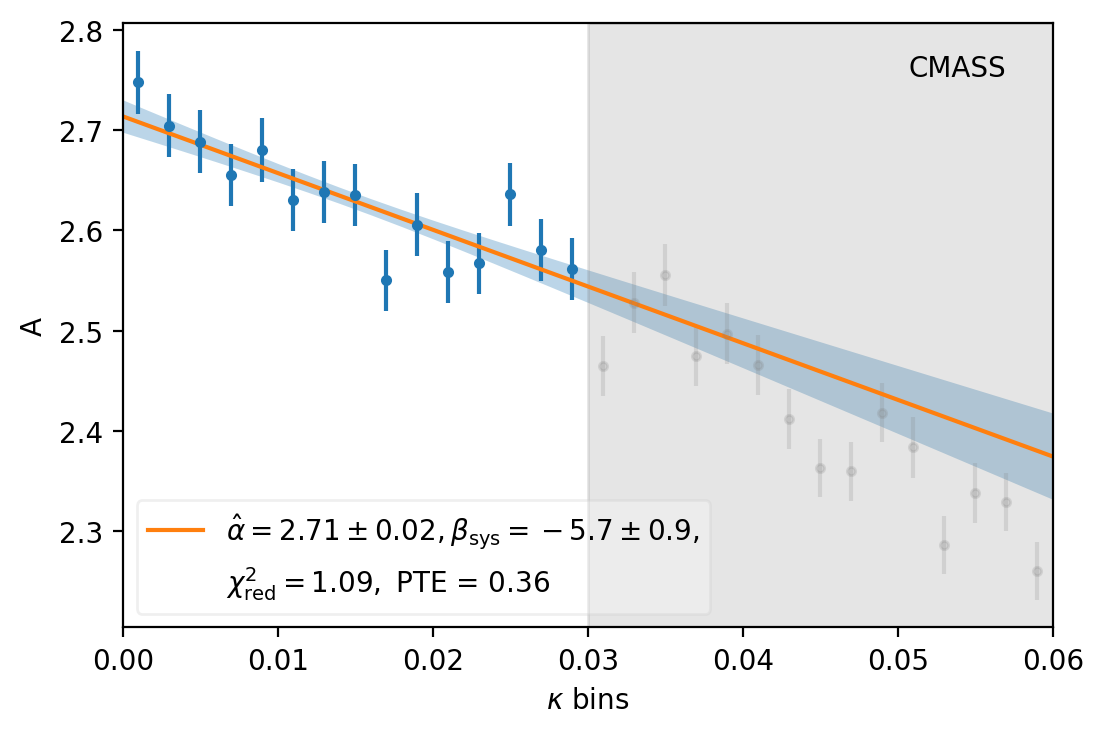

In [7]:
plt.figure(dpi=200)
alpha_CMASS = plot_fit_uptomax(result_CMASS, ii_min=0, ii_max=15, title="CMASS", xlim=0.06)